<a href="https://colab.research.google.com/github/katehee/X-ray_pneumonia_classification/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread
import random 
import cv2
random.seed(0)

from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
import cv2

drive.mount('/content/drive')

Mounted at /content/drive


##Import data

In [182]:
base = "/content/drive/MyDrive/Pneumonia/"
train_dir = base + "train/"
test_dir = base + "test/"
val_dir = base + "val/"

def dimension_lookup(dir, label): 
  shape0, shape1 = [], [] #height, width
  files = os.listdir(os.path.join(dir, label))
  for image_file_name in files: 
    shape = (cv2.imread(os.path.join(os.path.join(dir, label), image_file_name)).shape)
    shape0.append(shape[0])
    shape1.append(shape[1])

  print(str(dir).split("/")[5].upper(),  label)
  print("number of images: ", len(files))
  print("width range: ", min(shape1),'-', max(shape1))
  print("height range: ", min(shape0),'-', max(shape0))
  print("dimension of image: ", len(shape))
  print("=====================")

dimension_lookup(train_dir, "PNEUMONIA")
dimension_lookup(train_dir, "NORMAL")
dimension_lookup(test_dir, "PNEUMONIA")
dimension_lookup(test_dir, "NORMAL")
dimension_lookup(val_dir, "PNEUMONIA")
dimension_lookup(val_dir, "NORMAL")

TRAIN PNEUMONIA
number of images:  3933
width range:  127 - 2304
height range:  384 - 2772
dimension of image:  3
TRAIN NORMAL
number of images:  1359
width range:  672 - 2663
height range:  912 - 2916
dimension of image:  3
TEST PNEUMONIA
number of images:  390
width range:  344 - 1456
height range:  728 - 2000
dimension of image:  3
TEST NORMAL
number of images:  234
width range:  496 - 2713
height range:  984 - 2752
dimension of image:  3
VAL PNEUMONIA
number of images:  8
width range:  592 - 1128
height range:  968 - 1664
dimension of image:  3
VAL NORMAL
number of images:  8
width range:  928 - 1416
height range:  1240 - 1776
dimension of image:  3


In [ ]:
#@title
# from google.colab.patches import cv2_imshow

# files = os.listdir(os.path.join(train_dir, "PNEUMONIA"))
# for image_file_name in files[:1]: 
#   image = cv2.imread(os.path.join(os.path.join(train_dir, "PNEUMONIA"), image_file_name))
#   gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#   fig, ax = plt.subplots()
#   ax.imshow(gray, cmap='gray')
#   print(image.shape)
#   print(gray.shape)
#   ax.axis('off')

## Exploratory analysis

###charts
- pneumonia vs normal 
- pneumonia type (bacteria vs virus) pie chart

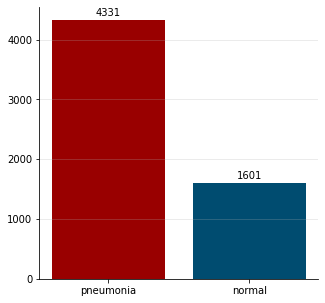

In [3]:
#@title 
total_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))) + len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
total_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL'))) + len(os.listdir(os.path.join(test_dir, 'NORMAL'))) + len(os.listdir(os.path.join(val_dir, 'NORMAL')))

#bar-chart pneumonia vs normal 
fig, ax =  plt.subplots(figsize = (5, 5))
ax.bar(['pneumonia','normal'], [total_num_pneumonia, total_num_normal], color = ('#990000', '#004c70'))
for s in ["top","right"]:
    ax.spines[s].set_visible(False)

#annotate y-value
for bar in ax.patches: 
  ax.annotate(f"{bar.get_height():.0f}", 
                   xy = (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 7), 
                   textcoords = 'offset points')

# y-axis tick
grid_y_ticks = np.arange(0, 4400, 1000)
ax.set_yticks(grid_y_ticks)
ax.grid(axis='y', linestyle='-', alpha=0.3)


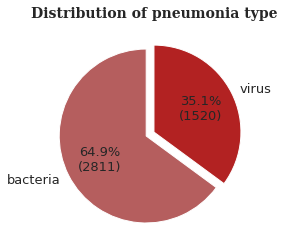

In [125]:
#@title 
total_pneumonia_filenames = os.listdir(os.path.join(train_dir, 'PNEUMONIA')) + os.listdir(os.path.join(test_dir, 'PNEUMONIA')) + os.listdir(os.path.join(val_dir, 'PNEUMONIA'))

virus_cnt, bacteria_cnt = 0, 0
for pneumonia_filename in total_pneumonia_filenames: 
  p_type = pneumonia_filename.split('_')[1]
  if p_type == "virus": 
    virus_cnt += 1
  elif p_type == "bacteria": 
    bacteria_cnt += 1
# print("total_pneumonia_cases: ", len(total_pneumonia_filenames))
# print("virus count: ", virus_cnt)
# print("bacteria count: ",bacteria_cnt)

#distribution of pneumonia type - pie chart
y = [bacteria_cnt, virus_cnt]
labels = ["bacteria", "virus"]
colors = ['#b55e5e','#b22222']
myexplode = [0.1, 0]
def prob(x): 
  return '{:.1f}'.format(x) + '%' + "\n" + '(' + '{:.0f}'.format(x/100 * 4331) + ')'

plt.title("Distribution of pneumonia type", fontsize=14, fontweight='bold', fontfamily='serif')
plt.pie(y, labels=labels, startangle=90, colors=colors, explode=myexplode, autopct=prob, textprops={'fontsize': 13})
plt.show()

###show images
- pneumonia images
- normal images

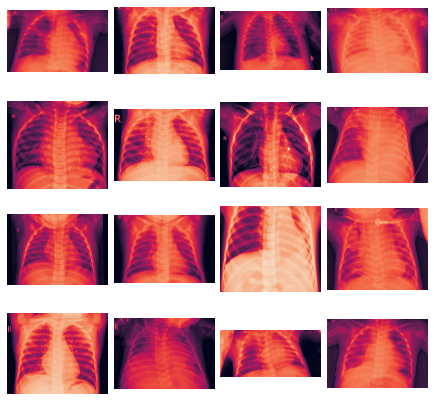

In [196]:
#@title
def show_images(dir, label, size): 
  image_names = os.listdir(os.path.join(dir, label))
  selected_images = random.sample(image_names, size*size) #random select 

  plt.figure(figsize=(6,6))
  for i in range(size*size): 
    plt.subplot(size, size, i + 1)
    image = cv2.imread(os.path.join(os.path.join(dir, label), selected_images[i]) , cv2.IMREAD_GRAYSCALE)
    plt.imshow(image)
    plt.axis('off')
  plt.tight_layout(pad=0.5)

show_images(train_dir, label="PNEUMONIA", size=4) #generate size * size image plot 

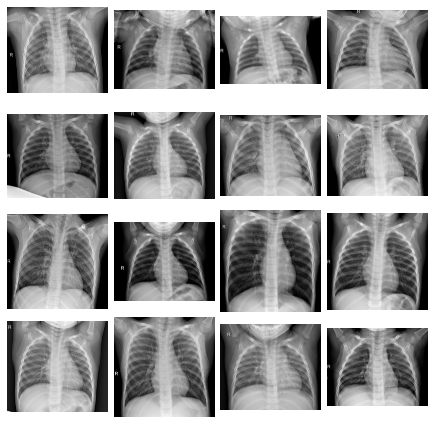

In [193]:
show_images(train_dir, label="NORMAL", size=4)

###pixel distribution

In [ ]:
#@title 
#gathering pixel min, max, mean, std information in the training set 
#pneumonia images from training set 
p_dir = base + "train/PNEUMONIA/" 
p_files = os.listdir(os.path.join(train_dir,'PNEUMONIA'))
p_images_min, p_images_max, p_images_mean, p_images_std = [], [], [], []
for p_file in tqdm(p_files): 
  p_image = cv2.imread(os.path.join(p_dir, p_file))
  p_images_min.append(int(p_image.min())) #int: round float to int 
  p_images_max.append(int(p_image.max()))
  p_images_mean.append(int(p_image.mean()))
  p_images_std.append(int(p_image.std()))

#normal images from training set 
n_dir = base + "train/NORMAL/" 
n_files = os.listdir(os.path.join(train_dir,'NORMAL'))
n_images_min, n_images_max, n_images_mean, n_images_std = [], [], [], []
for n_file in tqdm(n_files): 
  n_image = cv2.imread(os.path.join(n_dir, n_file))
  n_images_min.append(int(n_image.min())) #int: round float to int 
  n_images_max.append(int(n_image.max()))
  n_images_mean.append(int(n_image.mean()))
  n_images_std.append(int(n_image.std()))

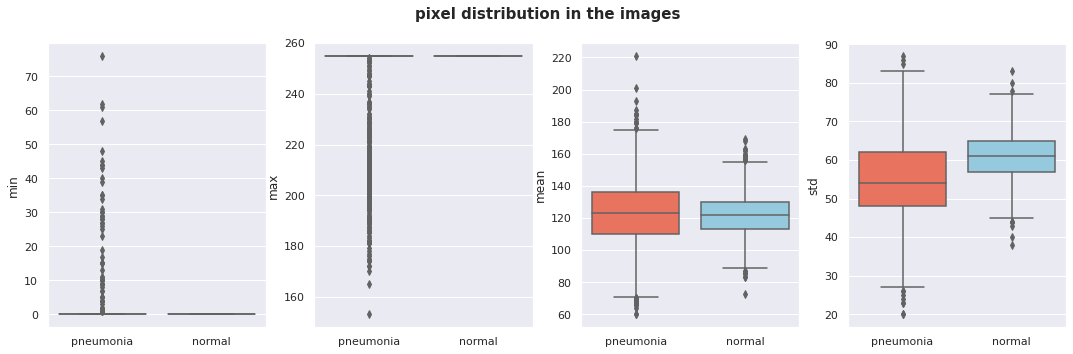

In [67]:
#@title 
p_df = pd.DataFrame()
p_df['min'] = p_images_min
p_df['max'] = p_images_max
p_df['mean'] = p_images_mean
p_df['std'] = p_images_std
p_df['type'] = 'pneumonia'

n_df = pd.DataFrame()
n_df['min'] = n_images_min
n_df['max'] = n_images_max
n_df['mean'] = n_images_mean
n_df['std'] = n_images_std
n_df['type'] = 'normal'

#merge dataframes 
df = pd.concat([p_df, n_df], axis=0)
pneumonia = df['type']  == 'pneumonia'
normal = df['type']== 'normal'
features = ['min','max','mean','std']
my_pal = {"pneumonia": "tomato", "normal": "skyblue"}

fig, axs = plt.subplots(1, len(features), figsize=(15,5))
fig.tight_layout()
sns.set(style="darkgrid")
fig.suptitle('pixel distribution in the images', fontsize=15, fontweight='bold')
for i in range(len(features)): 
    p = sns.boxplot(x=df['type'], y=df[features[i]], palette=my_pal, ax=axs[i])
    p.set_xlabel("")
    p.set_ylabel(features[i], fontsize=12)
fig.subplots_adjust(top=0.88)

In [198]:
#@title 
#gathering pixel min, max, mean, std information in the training set 
#pneumonia images from training set 
p_dir = base + "train/PNEUMONIA/" 
p_files = os.listdir(os.path.join(train_dir,'PNEUMONIA'))
p_images_min, p_images_max, p_images_mean, p_images_std = [], [], [], []
for p_file in tqdm(p_files[:1]): 
  p_image = cv2.imread(os.path.join(p_dir, p_file), cv2.IMREAD_GRAYSCALE)
  p_images_min.append(int(p_image.min())) #int: round float to int 
  p_images_max.append(int(p_image.max()))
  # p_images_mean.append(int(p_image.median()))
  p_images_std.append(int(p_image.std()))
print(p_image)
# #normal images from training set 
# n_dir = base + "train/NORMAL/" 
# n_files = os.listdir(os.path.join(train_dir,'NORMAL'))
# n_images_min, n_images_max, n_images_mean, n_images_std = [], [], [], []
# for n_file in tqdm(n_files): 
#   n_image = cv2.imread(os.path.join(n_dir, n_file), cv2.IMREAD_GRAYSCALE)
#   n_images_min.append(int(n_image.min())) #int: round float to int 
#   n_images_max.append(int(n_image.max()))
#   n_images_mean.append(int(n_image.median()))
#   n_images_std.append(int(n_image.std()))
# print(n_image.shape)
# p_df = pd.DataFrame()
# p_df['min'] = p_images_min
# p_df['max'] = p_images_max
# p_df['mean'] = p_images_mean
# p_df['std'] = p_images_std
# p_df['type'] = 'pneumonia'

# n_df = pd.DataFrame()
# n_df['min'] = n_images_min
# n_df['max'] = n_images_max
# n_df['mean'] = n_images_mean
# n_df['std'] = n_images_std
# n_df['type'] = 'normal'

# #merge dataframes 
# df = pd.concat([p_df, n_df], axis=0)
# pneumonia = df['type']  == 'pneumonia'
# normal = df['type']== 'normal'
# features = ['min','max','mean','std']
# my_pal = {"pneumonia": "tomato", "normal": "skyblue"}

# fig, axs = plt.subplots(1, len(features), figsize=(15,5))
# fig.tight_layout()
# sns.set(style="darkgrid")
# fig.suptitle('pixel distribution in the images', fontsize=15, fontweight='bold')
# for i in range(len(features)): 
#     p = sns.boxplot(x=df['type'], y=df[features[i]], palette=my_pal, ax=axs[i])
#     p.set_xlabel("")
#     p.set_ylabel(features[i], fontsize=12)
# fig.subplots_adjust(top=0.88)

100%|██████████| 1/1 [00:00<00:00, 35.21it/s]

[[ 0  0  0 ... 36 35 35]
 [ 0  0  0 ... 36 35 34]
 [ 0  0  0 ... 36 35 35]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [214]:
print(p_image.shape)
len(p_image)

(1164, 1600)


1164

#Image preprocessing
- resize images
- Augmentation